# 🏥 $FundusSw\ -\ Vision\ Transformer\ Model\ for\ Fundus\ Image\ Classification$
### 📌 **Model: ViT-Base-Patch16-224**
### 🔍 **Architecture & Training Details**
- **Backbone:** Vision Transformer (ViT)  
- **Preprocessing:** Rescale, Data Augmentation (Rotation, Shift, Flip, Zoom, Shear)  
- **Loss Function:** 🔥 Focal Loss (γ = 2.0, α = 0.25)  
- **Optimizer:** 🚀 AdamW with Mixed Precision  
- **Training Strategy:**
  - **Phase 1:** Train the Classification Head (10 epochs)  
  - **Phase 2:** Fine-tune the Full Model (40+ epochs)  
- **Callbacks:** Early Stopping, Model Checkpoint, LR Reduction  
- **Evaluation Metrics:** Accuracy, Precision, Recall, AUC  

---
⏳ **Training will start below...**

In [ ]:
import tensorflow as tf
from transformers import TFViTModel, ViTConfig
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Set parameters
img_size = 224
batch_size = 16
epochs = 50  # Increased epochs to allow for proper convergence

# Enhanced data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,  # Increased rotation
    width_shift_range=0.2,  # Increased shift
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # Added vertical flip
    fill_mode='reflect',  # Added reflection fill
    validation_split=0.2
)

# Separate validation data generator without augmentation
val_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2
)

def create_generators(train_dir):
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical",
        subset="training",
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical",
        subset="validation",
        shuffle=False
    )

    return train_generator, val_generator

class TensorTranspose(tf.keras.layers.Layer):
    def call(self, x):
        return tf.transpose(x, perm=[0, 3, 1, 2])

class VisionTransformerFeatureExtractor(tf.keras.layers.Layer):
    def __init__(self, trainable=True, **kwargs):
        super().__init__(**kwargs)

        config = ViTConfig.from_pretrained(
            'google/vit-base-patch16-224',
            image_size=img_size,
            num_channels=3
        )
        self.vit = TFViTModel.from_pretrained(
            'google/vit-base-patch16-224',
            config=config
        )
        # Make ViT layers trainable or not
        self.vit.trainable = trainable
        self.transpose = TensorTranspose()

    def call(self, inputs, training=False):
        x = tf.cast(inputs, tf.float32)
        x = (x * 2.0) - 1.0
        x = self.transpose(x)
        outputs = self.vit(x, training=training)
        return outputs.last_hidden_state[:, 0]

class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        cross_entropy = -y_true * tf.math.log(y_pred)
        focal_weight = tf.pow(1 - y_pred, self.gamma) * y_true

        return tf.reduce_mean(self.alpha * focal_weight * cross_entropy)

def create_vit_model(num_classes):
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))

    # Feature extractor with frozen layers initially
    feature_extractor = VisionTransformerFeatureExtractor(trainable=False)
    x = feature_extractor(inputs)

    # Enhanced classification head
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dense(1024, activation="gelu")(x)  # Increased units
    x = tf.keras.layers.Dropout(0.2)(x)  # Increased dropout
    x = tf.keras.layers.Dense(512, activation="gelu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Custom optimizer with gradient clipping
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=1e-4,
        weight_decay=0.01,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-8
    )
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

    # Using focal loss instead of categorical crossentropy
    focal_loss = FocalLoss(gamma=2.0, alpha=0.25)

    model.compile(
        optimizer=optimizer,
        loss=focal_loss,
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )

    return model, feature_extractor

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()

def train_model(model, feature_extractor, train_generator, val_generator, class_weights_dict):
    callbacks = [
        ModelCheckpoint(
            "/content/drive/MyDrive/Fundus-ModelData/FundusSw_best.weights.h5",
            monitor="val_auc",  # Changed to AUC metric
            mode="max",
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor="val_auc",
            mode="max",
            patience=5,  # Increased patience
            restore_best_weights=True,
            min_delta=0.001,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor="val_auc",
            mode="max",
            factor=0.5,
            patience=2,
            min_lr=1e-7,
            min_delta=0.001,
            verbose=1
        )
    ]

    # First phase: Train only the classification head
    print("Phase 1: Training classification head...")
    history1 = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=callbacks,
        class_weight=class_weights_dict
    )

    # Second phase: Fine-tune the entire model
    print("Phase 2: Fine-tuning entire model...")
    feature_extractor.trainable = True

    # Recompile with a lower learning rate
    model.optimizer.learning_rate = 1e-5

    history2 = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs-10,
        callbacks=callbacks,
        class_weight=class_weights_dict
    )

    # Combine histories
    combined_history = {}
    for k in history1.history.keys():
        combined_history[k] = history1.history[k] + history2.history[k]

    return tf.keras.callbacks.History().set_params({'history': combined_history})

def evaluate_model(model, val_generator):
    # Get predictions
    predictions = model.predict(val_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = val_generator.classes

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes,
                              target_names=list(val_generator.class_indices.keys())))

    # Print confusion matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(true_classes, predicted_classes))

def main(train_dir):
    # Enable mixed precision
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

    # Create generators
    train_generator, val_generator = create_generators(train_dir)
    num_classes = len(train_generator.class_indices)

    # Print class mapping
    print("Class indices:", train_generator.class_indices)

    # Ensure the correct label mapping (swap if needed)
    if train_generator.class_indices == {'0_Normal': 0, '1_Abnormal': 1}:
        print("Reversing class labels to match expected order")
        class_mapping = {0: 1, 1: 0}  # Swap Normal and AbNormal labels
        train_generator.classes = np.vectorize(class_mapping.get)(train_generator.classes)
        val_generator.classes = np.vectorize(class_mapping.get)(val_generator.classes)

    # Compute class weights
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_generator.classes),
        y=train_generator.classes
    )
    class_weights_dict = dict(enumerate(class_weights))
    print("Class weights:", class_weights_dict)

    # Create and train model
    model, feature_extractor = create_vit_model(num_classes)
    history = train_model(model, feature_extractor, train_generator, val_generator, class_weights_dict)

    # Plot training history
    plot_training_history(history)

    # Evaluate model
    print("\nEvaluating model...")
    evaluate_model(model, val_generator)

    # Save final model
    model.save_weights("/content/drive/MyDrive/Fundus-ModelData/FundusSw_final.weights.h5")

    return model, history

if __name__ == "__main__":
    train_dir = "/content/drive/MyDrive/Fundus-ModelData/Train-Imgs"
    model, history = main(train_dir)

### ⚙️ $Prediction\ Process$
- ✅ **Load the best trained model.**
- 🖼 **Preprocess Input Image:** Resize (224x224), Normalize, Expand Dimensions  
- 🤖 **Model Inference:** Predict class probabilities  
- 📊 **Decision Threshold:** 0.5 (Softmax Activation)  
- 🏷 **Final Output:**  
  - **🟢 Normal** (Low Alzheimer’s risk)  
  - **🔴 AbNormal** (Potential Alzheimer’s risk)  

---
⏳ **Running Predictions...**


In [ ]:
!pip install fpdf

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer '

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━

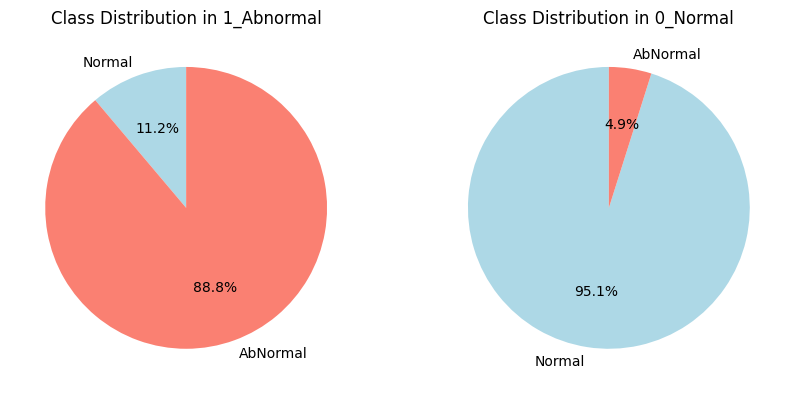

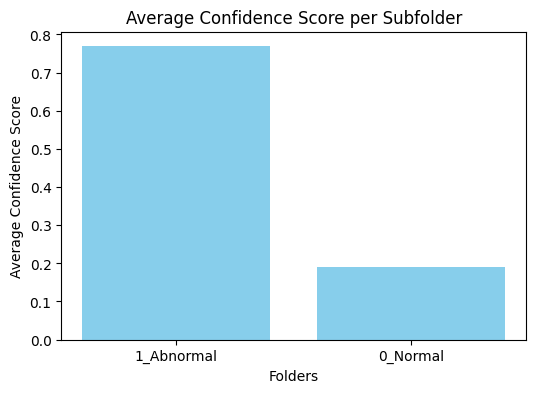

In [5]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from fpdf import FPDF
from google.colab import drive

# 🚀 Mount Google Drive
drive.mount('/content/drive')

# 🔍 Define paths
model_path = "/content/drive/MyDrive/Fundus-ModelData/FundusSw_best.weights.h5"  # Update with your saved model path
test_folder = "/content/drive/MyDrive/Fundus-ModelData/Test-Imgs"  # Folder containing subfolders with images
output_pdf_path = "/content/drive/MyDrive/Fundus-ModelData/Saved-Models-Reports/4-FundusViT-B16-VisionTransformer/ghjkl.pdf" #added .pdf extension

# Assuming create_vit_model is defined in the previous cell or imported
# from your training script
# the following import is incorrect and has been removed
# from ipython-input-29-13fe66004ef2 import create_vit_model, img_size # Import create_vit_model
# Assuming create_vit_model is defined elsewhere and imported correctly

# 🧠 Load Trained Model
# 1. Recreate the model using the create_vit_model function
num_classes = 2  # Update with the actual number of classes in your model

# Recreate the model architecture before loading the weights
model, feature_extractor = create_vit_model(num_classes)

# 2. Load the saved weights into the model
model.load_weights(model_path)

# 🖼 Preprocess Image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))  # Resize
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# 📂 Process Images & Predict
results = []
class_counts = {}  # For Pie Chart
confidence_scores = {}  # For Average Confidence Chart
threshold = 0.5  # Sigmoid activation threshold

for subfolder in os.listdir(test_folder):
    subfolder_path = os.path.join(test_folder, subfolder)

    if os.path.isdir(subfolder_path):  # Ensure it's a folder
        class_counts[subfolder] = {"Normal": 0, "AbNormal": 0}
        confidence_scores[subfolder] = []

        for image_name in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_name)

            # Predict class
            img_array = preprocess_image(image_path)
            prediction = model.predict(img_array)[0][0]
            predicted_class = "AbNormal" if prediction > threshold else "Normal"
            confidence_score = round(prediction, 4)

            # Track counts & confidence
            class_counts[subfolder][predicted_class] += 1
            confidence_scores[subfolder].append(confidence_score)

            # Store results
            results.append([image_name, subfolder, predicted_class, confidence_score])

# 📝 Convert results to DataFrame
df = pd.DataFrame(results, columns=["Image Name", "Folder", "Predicted Class", "Confidence Score"])

# 🎨 Generate Data Visualizations
fig, axes = plt.subplots(1, len(class_counts), figsize=(10, 5))
for i, (folder, counts) in enumerate(class_counts.items()):
    labels = counts.keys()
    sizes = counts.values()
    axes[i].pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90, colors=["lightblue", "salmon"])
    axes[i].set_title(f"Class Distribution in {folder}")
plt.savefig("/content/class_distribution.png")

# 📊 Average Confidence per Folder
avg_confidence = {folder: np.mean(scores) for folder, scores in confidence_scores.items()}
plt.figure(figsize=(6, 4))
plt.bar(avg_confidence.keys(), avg_confidence.values(), color="skyblue")
plt.xlabel("Folders")
plt.ylabel("Average Confidence Score")
plt.title("Average Confidence Score per Subfolder")
plt.savefig("/content/avg_confidence.png")

# 📄 Generate PDF Report
class PDF(FPDF):
    def header(self):
        self.set_font("Times", "B", 16)
        self.cell(275, 10, "Fundus Image Classification Report", ln=True, align="C")

    def footer(self):
        self.set_y(-15)
        self.set_font("Times", "I", 10)
        self.cell(0, 10, f"Page {self.page_no()}", align="C")

# 📑 Create PDF
pdf = PDF(orientation="L")  # Landscape Mode
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()
pdf.set_font("Times", size=12)

# 🏷 Report Header
pdf.set_font("Times", "B", 14)
pdf.cell(0, 10, "Model Details", ln=True)
pdf.set_font("Times", size=12)
pdf.cell(0, 10, f"Model Name: FundusViT-B16", ln=True)
#pdf.cell(0, 10, f"Model Path: {model_path}", ln=True)
pdf.cell(0, 10, "Author: Danish A. G.", ln=True)
pdf.ln(10)

# 📋 Results Table
pdf.set_font("Times", "B", 12)

# Adjusted Column Widths
pdf.cell(140, 10, "Image Name", 1)  # Increased width
pdf.cell(40, 10, "Folder", 1)
pdf.cell(40, 10, "Predicted Class", 1)
pdf.cell(50, 10, "Confidence Score", 1)
pdf.ln()

pdf.set_font("Times", size=12)
for idx, row in df.iterrows():
    pdf.cell(140, 10, row["Image Name"], 1)  # Adjusted width
    pdf.cell(40, 10, row["Folder"], 1)
    pdf.cell(40, 10, row["Predicted Class"], 1)
    pdf.cell(50, 10, str(row["Confidence Score"]), 1)
    pdf.ln()

# 📊 Insert Pie Charts
pdf.ln(10)
pdf.cell(0, 10, "Class Distribution", ln=True, align="L")
pdf.image("/content/class_distribution.png", x=10, w=250)

# 📉 Insert Average Confidence Score Chart
pdf.ln(10)
pdf.cell(0, 10, "Average Confidence Score per Subfolder", ln=True, align="L")
pdf.image("/content/avg_confidence.png", x=10, w=250)

# 💾 Save PDF to Drive
pdf.output(output_pdf_path)
print(f"✅ Report saved at: {output_pdf_path}")